In [1]:
pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
!pip install xgboost

In [3]:
!pip install sklearn-genetic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [sklearn-genetic]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from genetic_selection import GeneticSelectionCV
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc




```
# This is formatted as code
```

**Loading dataset**

In [5]:
df=pd.read_csv('creditcard.csv')
print("Rows in dataset",df.shape[0])
print("Columns in dataset", df.shape[1])
df.head(3)

Rows in dataset 284807
Columns in dataset 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


***Columns in Dataset***

In [6]:
print("Columns in dataset:")
df.columns

Columns in dataset:


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

**Drop unnecessary columns**

In [7]:
df.drop(["Time"],axis=1,inplace=True)


In [8]:
df.dtypes

,0
V1,float64
V2,float64
V3,float64
V4,float64
V5,float64
V6,float64
V7,float64
V8,float64
V9,float64
V10,float64


**Check null values**

In [9]:
df.isna().sum()

,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0
V10,0


**Identifying patterns**

In [10]:
df_fraud=df[df['Class']==1]
df_true=df[df['Class']==0]
df_true=df_true.sample(frac=0.5)
data=pd.concat([df_true,df_fraud])
data=data.reset_index(drop=True)
data.shape

(142650, 30)

In [11]:
data['Amount'].describe()

,Amount
count,142650.000000
mean,87.925472
std,236.484862
min,0.000000
25%,5.640000
50%,21.970000
75%,77.000000
max,11898.090000


**Visualizing the distribution of class**

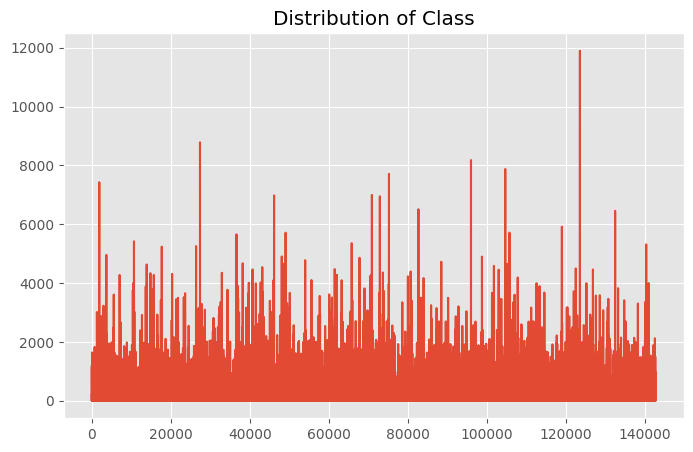

In [12]:
with plt.style.context(('ggplot')):
  plt.figure(figsize=(8,5))
  plt.title("Distribution of Class")
  plt.plot(data['Amount'])
  plt.show()

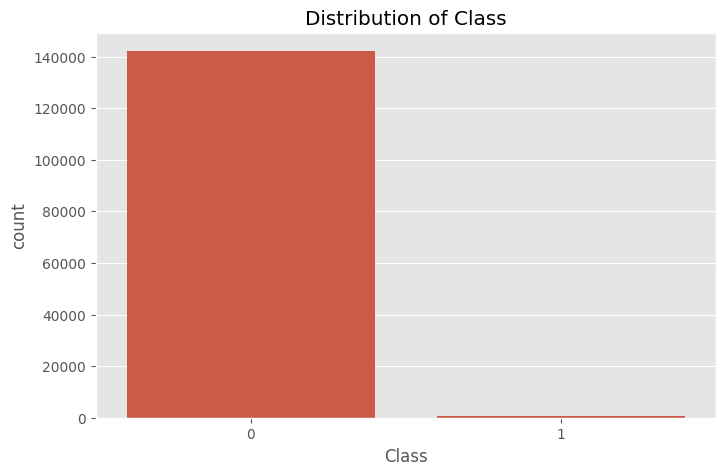

In [13]:
with plt.style.context('ggplot'):
  plt.figure(figsize=(8,5))
  plt.title("Distribution of Class")
  sns.countplot(x=data["Class"],data=data)
  plt.show()


**Percentage of frauds**

In [14]:
fraud_per=round(len(df[df.Class==1])/len(df[df.Class==0])*100, 2)
print(f"Percentage of fraud detections {fraud_per} %")

Percentage of fraud detections 0.17 %


**Scaling the amount column with standard scaling process**

In [15]:
sc=StandardScaler()
data.Amount=sc.fit_transform(data.Amount.values.reshape(-1,1))

**Amount after transformation**

In [16]:
data.Amount

,Amount
0,-0.347784
1,-0.356157
2,-0.367574
3,0.264181
4,-0.276659
...,...
142645,1.277357
142646,-0.368589
142647,-0.042436
142648,0.664208


**Droping duplicate columns**

In [17]:
data.drop_duplicates(inplace=True)
data.shape

(139526, 30)

**Train-Test Split**

In [18]:
x=data.drop(['Class'],axis=1)
y=data['Class']
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8)


**Logistic Regression**

In [19]:
model_log=LogisticRegression()
model_log.fit(x_train,y_train)
y_pred_log=model_log.predict(x_test)
print(f"The accuracy of model is {round(model_log.score(x_test,y_test)*100,2)}%")


The accuracy of model is 99.89%


**F1-Score Logistic Regression**

In [20]:
print(f"The F1 score is : {round(f1_score(y_test,y_pred_log),2)}")

The F1 score is : 0.83


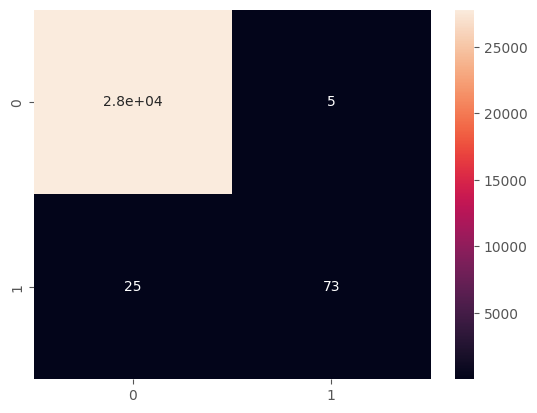

In [21]:
with plt.style.context(('ggplot')):
  sns.heatmap(confusion_matrix(y_test,y_pred_log),annot=True)


**Random Forest Classifier**

In [22]:
model=RandomForestClassifier()
model.fit(x_train,y_train)
y_pred_random=model.predict(x_test)


In [23]:
print(f"The accuracy of model is {round(model.score(x_test,y_test)*100,2)}%")

The accuracy of model is 99.94%


In [24]:
print(f"The F1 score is : {round(f1_score(y_test,y_pred_random),2)}")

The F1 score is : 0.9


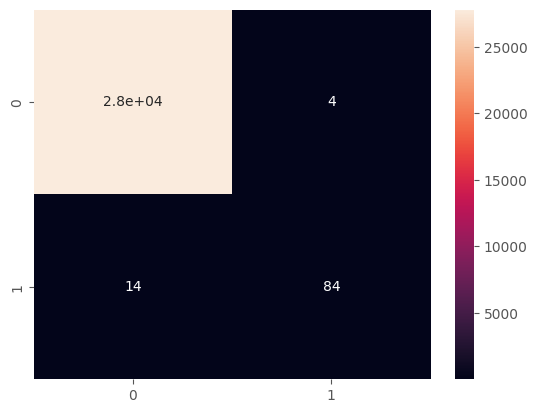

In [25]:
with plt.style.context(('ggplot')):
  sns.heatmap(confusion_matrix(y_test,y_pred_random),annot=True)


In [27]:
!pip install sklearn-genetic-opt

**Using Genetic Algorithm with Logistic Regression**

In [30]:
estimator_log=LogisticRegression()
model_ga_log=GeneticSelectionCV(estimator=estimator_log,cv=5,scoring="accuracy",max_features=5,n_population=60,n_gen_no_change=6)
model_ga_log.fit(x_train,y_train)
y_log_ga=model_ga_log.predict(x_test)

TypeError: got an unexpected keyword argument 'fit_params'

In [ ]:
print(f"The accuracy of model is {round(model_ga_log.score(x_test,y_test)*100,2)}%")

In [ ]:
print(f"The F1 score is : {round(f1_score(y_test,y_log_ga),2)}")

In [ ]:
with plt.style.context(('ggplot')):
  sns.heatmap(confusion_matrix(y_test,y_log_ga),annot=True)


**Applying Xgboost Model**

In [31]:
model_xgb=XGBClassifier()
model_xgb.fit(x_train,y_train)
y_pred_xgb=model_xgb.predict(x_test)

In [32]:
print(f"The accuracy of model is {round(model_xgb.score(x_test,y_test)*100,2)}%")

The accuracy of model is 99.93%


In [33]:
print(f"The F1 score is : {round(f1_score(y_test,y_pred_xgb),2)}")

The F1 score is : 0.89


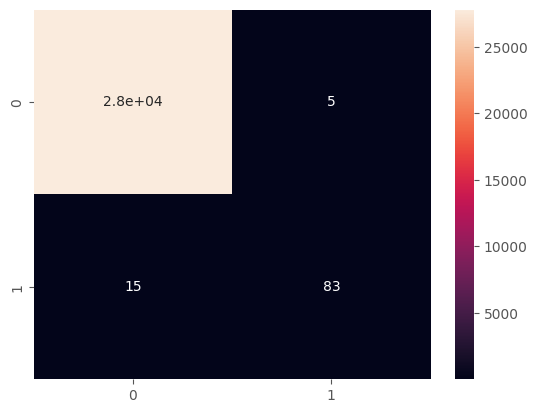

In [34]:
with plt.style.context(('ggplot')):
  sns.heatmap(confusion_matrix(y_test,y_pred_xgb),annot=True)


**Generating ROC-AUC curve**

**Calculating ROC-CUV curve for XGboost model**

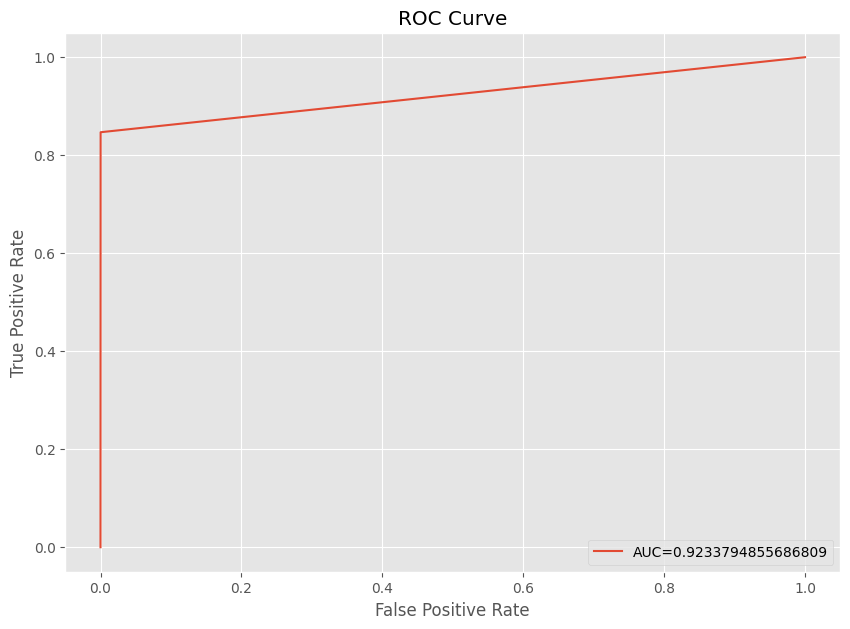

In [36]:
fpr,tpr,_=metrics.roc_curve(y_test,y_pred_xgb)
auc_score=metrics.roc_auc_score(y_test,y_pred_xgb)

#create ROC curve
with plt.style.context(('ggplot')):
  plt.figure(figsize=(10,7))
  plt.title("ROC Curve")
  plt.plot(fpr,tpr,label="AUC="+str(auc_score))
  plt.ylabel("True Positive Rate")
  plt.xlabel("False Positive Rate")
  plt.legend(loc=4)
  plt.show()